In [50]:
!tree -dL 2 input/

input/

0 directories


In [51]:
# generic librairies
import time as time
import numpy as np
import pandas as pd
import gc

# Text librairies
import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tag.util import untag
import contractions
# import pycontractions # Alternative better package for removing contractions
from autocorrect import Speller


from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import mglearn
from cycler import cycler

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['image.cmap'] = "viridis"
plt.rcParams['image.interpolation'] = "none"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.numpoints'] = 1
#plt.rc('axes', prop_cycle=(
#    cycler('color', mglearn.plot_helpers.cm_cycle.colors) +
#    cycler('linestyle', ['-', '-', "--", (0, (3, 3)), (0, (1.5, 1.5))])))

np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('precision', 2)

__all__ = ['np', 'mglearn', 'display', 'plt', 'pd']

# Load Data

In [52]:
%%time

# https://numpy.org/devdocs/user/basics.types.html

dtypes_questions = {'Id':'int32', 'Score': 'int16', 'Title': 'str', 'Body': 'str', 'Text': 'str'}

df_questions = pd.read_csv('df_questions_fullclean.csv',
                           usecols=['Id', 'Score', 'Title', 'Body','Text'], 
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           nrows=10000
                          )

CPU times: user 13.3 ms, sys: 3.94 ms, total: 17.2 ms
Wall time: 16.1 ms


In [53]:
df_questions

,Id,Title,Body,Score,Text
0,1544907,melt two column,follow variable data frame type ialt idx idx i...,26,melt two column follow variable data frame typ...
1,195625,time complexity pop element list python,wonder time complexity pop list object python ...,55,time complexity pop element list python wonder...
2,6052631,data monthyear interval,often work date imagine fairly column represen...,62,data monthyear interval often work date imagin...
3,8809004,escape roxygen style documentation,let u say comment block would like email addre...,20,escape roxygen style documentation let u say c...
4,1355355,loop select item list,could solve use loop try think vector code lis...,31,loop select item list could solve use loop try...
...,...,...,...,...,...
1995,863774,generate xml document namespaces python,try generate xml document namespaces currently...,24,generate xml document namespaces python try ge...
1996,2281353,row name column name,follow function pair generate exactly result n...,53,row name column name follow function pair gene...
1997,425990,django ironpython,get django run anyone success get run level su...,52,django ironpython get django run anyone succes...
1998,165495,detect mouse click windows use python,detect mouse click regardless mouse perferabli...,24,detect mouse click windows use python detect m...


In [54]:
text_train = df_questions.Text
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[6]:\n{}".format(text_train[6]))

type of text_train: <class 'pandas.core.series.Series'>
length of text_train: 2000
text_train[6]:
question setuptools alternative see bit setuptools bash internet lately recently read james bennett package post one use time freenode know soul absolutely would count among actually use setuptools project deficiency would prefer something well particularly egg format deploy setuptools problem find tool like pip mean easyinstall replacement setuptools fact use component package make use setuptoolsaware declare dependency bdist bdistegg pypi want switch use kind change would need make easyinstall dependency dependency declare guess would need get away use egg provide source distribution generate directory even need would change virtualenv virtualenv use manage environment would change setuptools provide develop command use basically try get picture development look like anyone suggest look solution mainly linux deb package option reason bicking outline


# Representer le texte en "Bag of Words"

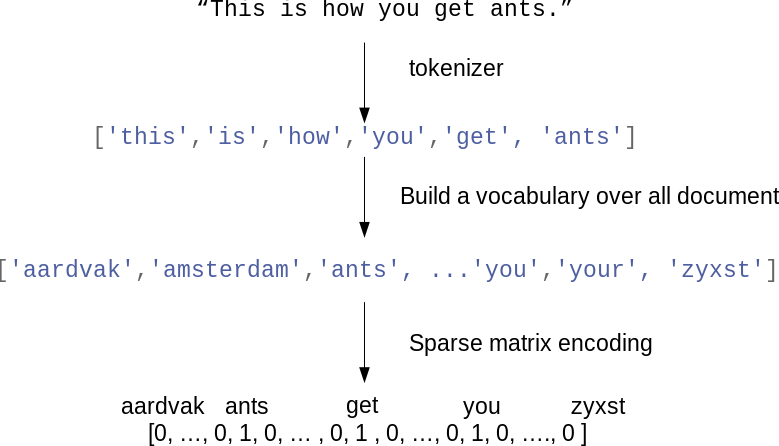

In [55]:
# faire un test de bag of words

bards_words =["The fool doth think he is wise,",
              "but the wise man knows himself to be a fool"]

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer()

In [57]:
print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("Vocabulary content:\n {}".format(vect.vocabulary_))

Vocabulary size: 13
Vocabulary content:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [58]:
bag_of_words = vect.transform(bards_words)
print("bag_of_words: {}".format(repr(bag_of_words)))

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


In [59]:
print("Dense representation of bag_of_words:\n{}".format(
    bag_of_words.toarray()))

Dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


## bag-of-words de Post

In [60]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<2000x11737 sparse matrix of type '<class 'numpy.int64'>'
	with 61199 stored elements in Compressed Sparse Row format>


In [61]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 5010 to 5030:\n{}".format(feature_names[5010:5030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 11737
First 20 features:
['aa', 'aaa', 'aaaaa', 'aaaarghxxx', 'aaardvark', 'aaaxxx', 'aabbcdefg', 'aabsiddfdfdatatg', 'aacute', 'aardvark', 'aavec', 'aazqmaso', 'ab', 'abbrach', 'abbreche', 'abbreviation', 'abc', 'abca', 'abcabcdefabcd', 'abcdc']
Features 5010 to 5030:
['indices', 'individually', 'indr', 'industry', 'inefficiency', 'inefficient', 'inefficienttoo', 'inevitably', 'inf', 'infection', 'infer', 'inferior', 'infile', 'infinity', 'info', 'infographics', 'inform', 'information', 'informationrich', 'infrastructure']
Every 2000th feature:
['aa', 'could', 'functionnames', 'lubridate', 'pros', 'strsignum']


## bag-of-word avec plus d'un mot (n-grams)

In [62]:
print("bards_words:\n{}".format(bards_words))

bards_words:
['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


In [63]:
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 13
Vocabulary:
['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


In [64]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 14
Vocabulary:
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


In [65]:
print("Transformed data (dense):\n{}".format(cv.transform(bards_words).toarray()))

Transformed data (dense):
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


In [66]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 39
Vocabulary:
['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


# Modélisation automatique des sujets

## LDA, Latent Dirichlet Allocation
L'objectif de ce type de modélisation de sujets est de récupérer de potentielles catégories pour des traitements ultérieurs. Cette modélisation offre surtout une meilleure compréhension de la structuration du texte en vue de création de features manuelles (mettre l'accent sur certains mots, comprendre ce qui définit une catégorie, etc.)


In [67]:
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

max_df : float in range [0.0, 1.0] or int, default=1.0
    When building the vocabulary ignore terms that have a document
    frequency strictly higher than the given threshold (corpus-specific
    stop words).

In [68]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10,
                                learning_method="online",
                                learning_offset=50.,
                                max_iter=25,
                                random_state=0)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

In [69]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 10000)


In [70]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
feature_names = np.array(vect.get_feature_names())

In [71]:
#fonction du livre introduction_to_ml_with_python-master

def print_topics(topics, feature_names, sorting, topics_per_chunk=6,
                 n_words=20):
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")

In [72]:
# Print out the 10 topics:

print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
medium        thread        array         form          folder        
word          password      ej            diagram       exception     
link          email         hello         vp            green         
capitalize    send          tag           layoutposcol  idx           
port          piece         world         viewportlayoutposrowpyexe         
octave        company       matplotlib    tank          farve         
gui           daemon        datetime      gfortran      subfolders    
pyqt          form          timezone      selfcleaneddatarecompiles    
title         attachment    metaclasses   title         vista         
form          queue         myclass       lars          melt          


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------    

In [73]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method="batch",
                                   max_iter=25, random_state=0)
document_topics100 = lda100.fit_transform(X)

In [74]:
topics = np.array([2,7, 16, 24, 25, 28, 36, 37, 41, 45, 51, 53, 54, 63, 89, 97])

In [75]:
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
print_topics(topics=topics, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=8, n_words=10)

topic 2       topic 7       topic 16      topic 24      topic 25      topic 28      topic 36      topic 37      
--------      --------      --------      --------      --------      --------      --------      --------      
language      gui           exception     rule          pm            number        object        image         
look          make          date          message       oct           letter        title         template      
ruby          map           handle        engine        dec           site          name          html          
program       wxpython      except        match         november      print         plot          folder        
correlation   program       throw         google        jan           django        package       render        
error         solution      error         look          april         app           follow        package       
java          look          follow        app           th            order         save        

In [76]:
# sort by weight of "function" topic 36
function = np.argsort(document_topics100[:, 63])[::-1]
# print the five documents where the topic is most important
for i in function[:5]:
    # show first two sentences
    print(".".join(text_train[i].split(".")[:2]) + ".\n")

pvalue aov look pvalue generate run test aovasq asq yield df sum mean sq value prf asq residual signif code observation delete look structure see usually work list get need time one google search also seem reveal simpler structure get note asq data frame list coefficient name num name chr asq residual name num name effect name num name chr intercept asq int fittedvalues name num name chr int list qr num dimnameslist chr chr intercept assign int qraux num pivot int tol num rank int attr class chr qr int naaction class omit name int attr name chr xlevels list language aovformula asq term class term formula length asq asq attr variable language listasq factor int dimnameslist chr asq asq chr asq attr termlabels chr order int attr intercept int attr response int attr environmentenvironment rglobalenv attr predvars language listasq attr dataclasses name attr name chr model dataframe variable asq int asq int attr termsclasses term length asq asq attr variable language listasq factor int dimn

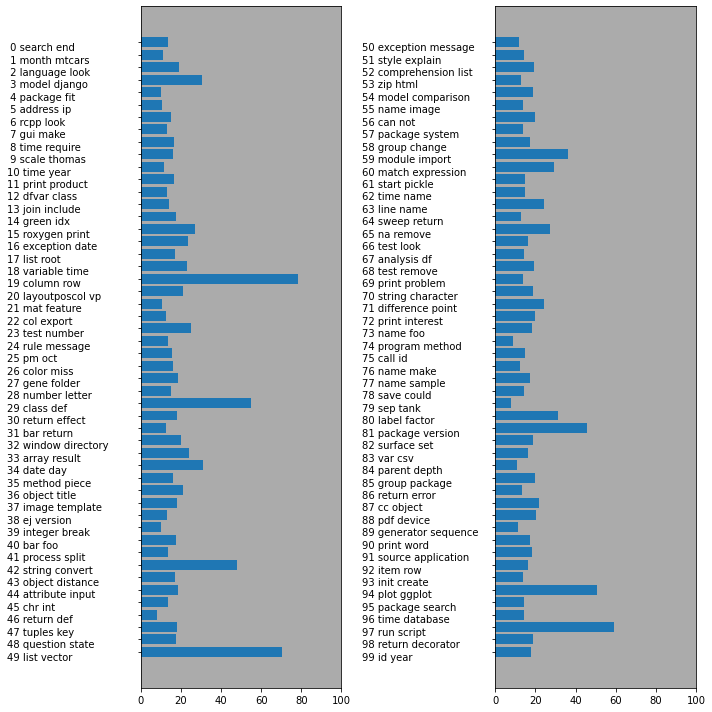

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]
# two column bar chart:
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 100)
    ax[col].patch.set_facecolor('#ababab')
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()
fig.patch.set_facecolor('w')


In [78]:
### Utiliser le modèle LDA entrainé pour faire des prédictions et proposer des nouveaux mots
#catégoriser nouvelles entrés avec le modèle entrainé
#new_post = ['I love this movie and never get tired of watching. The music in it is great.']
new_post = [text_train[25]] # test sur des post du dataset
new_post_vect = vect.transform(new_post)
post_topics100 = lda100.transform(new_post_vect)
rating = np.sort(post_topics100[0,:])[::-1][:2]
tag = np.argsort(post_topics100[0,:])[::-1][:2]
print(new_post[0])
print(rating)
print_topics(topics=tag, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=5)

find function include package know mvbutils apparently neither find function method internally getanywhere source file directory source package use environment must better way
[0.32  0.249]
topic 11      topic 81      
--------      --------      
print         package       
product       version       
string        instal        
type          load          
str           install       




## NMF - Negative Matrix Factorisation

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
    min_df=2, 
    max_features=no_features, 
    stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(text_train)
tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names())

no_topics = 100

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf)

nmf_topics = nmf.transform(tfidf)

no_top_words = 5

sorting_nmf = np.argsort(nmf.components_, axis=1)[:, ::-1]
print_topics(topics=range(20), feature_names=tfidf_feature_names,
                           sorting=sorting_nmf, topics_per_chunk=8, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       topic 7       
--------      --------      --------      --------      --------      --------      --------      --------      
zone          data          file          function      plot          class         string        def           
extend        frame         read          work          curve         instance      match         initself      
field         read          csv           apply         rnorm         define        letter        decorator     
feel          work          write         pass          point         initself      pattern       docstring     
feature       need          directly      environment   pdf           reference     know          init          
fast          structure     include       define        graph         member        split         kwargs        
far           column        download      parameter     create        inheritance   contain     

In [80]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join(
            [feature_names[i] for i in topic.argsort()[::-1][:no_top_words]]))

display_topics(nmf, tfidf_feature_names, no_top_words)


Topic 0:
zone extend field feel feature
Topic 1:
data frame read work need
Topic 2:
file read csv write directly
Topic 3:
function work apply pass environment
Topic 4:
plot curve rnorm point pdf
Topic 5:
class instance define initself reference
Topic 6:
string match letter pattern know
Topic 7:
def initself decorator docstring init
Topic 8:
package instal install source dependency
Topic 9:
vector length paste want contain
Topic 10:
error message try follow condition
Topic 11:
na dataframe result cna chr
Topic 12:
value key dict miss zero
Topic 13:
row dataframe condition select apply
Topic 14:
element suppose access want basically
Topic 15:
datetime timezone year exactly today
Topic 16:
date calculate ymd asdate posixct
Topic 17:
print statement hello letter space
Topic 18:
line end stdin split traceback
Topic 19:
way add say follow define
Topic 20:
column dataframe df frame columns
Topic 21:
script parameter execute want rscript
Topic 22:
object attribute workspace create environment


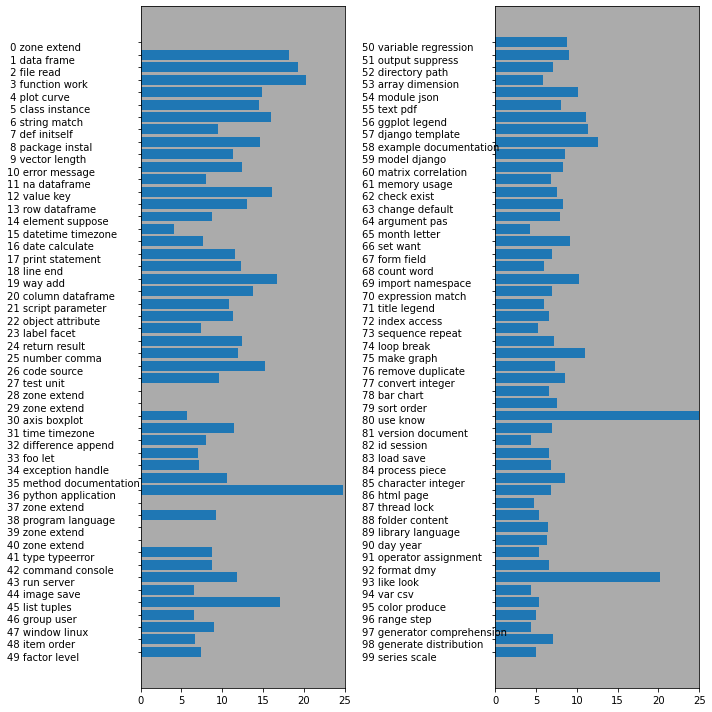

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(tfidf_feature_names[sorting_nmf[:, :2]])]
# two column bar chart:
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(nmf_topics, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 25)
    ax[col].patch.set_facecolor('#ababab')
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()
fig.patch.set_facecolor('w')


In [82]:
### Utiliser le modèle NMF entrainé pour faire des prédictions et proposer des nouveaux mots
#catégoriser nouvelles entrés avec le modèle entrainé
#new_post = ['I love this movie and never get tired of watching. The music in it is great.']
new_post = [text_train[25]] # test sur des post du dataset
new_post_vect = tfidf_vectorizer.transform(new_post)
post_topics100 = nmf.transform(new_post_vect)
rating = np.sort(post_topics100[0,:])[::-1][:2]
tag = np.argsort(post_topics100[0,:])[::-1][:2]
print(new_post[0])
print(rating)
print_topics(topics=tag, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=5)

find function include package know mvbutils apparently neither find function method internally getanywhere source file directory source package use environment must better way
[0.141 0.125]
topic 8       topic 52      
--------      --------      
time          comprehension 
require       list          
return        parameter     
look          figure        
order         generator     


